In [1]:
import pandas as pd
import requests
from bs4 import BeautifulSoup
from sqlalchemy import create_engine
import time

In [2]:
# Load your CSV
df = pd.read_csv("final_joined_table.csv")[['track_id', 'title', 'artist', 'emotion']]
df.dropna(subset=['title', 'artist'], inplace=True)
df.drop_duplicates(subset=['title', 'artist'], inplace=True)

In [3]:
# Genius API token
GENIUS_API_TOKEN = 'TgBTMTcioYijFuOJRkbdRWusG0JiiFMyEq1lsNq_1q_mQI3gR8NRBOWSCjHyHsKv'
headers = {"Authorization": f"Bearer {GENIUS_API_TOKEN}"}

# SQLite setup
engine = create_engine("sqlite:///lyrics.db")

In [4]:
def get_genius_url(title, artist):
    query = f"{title} {artist}"
    url = f"https://api.genius.com/search?q={requests.utils.quote(query)}"
    response = requests.get(url, headers=headers).json()
    try:
        return response["response"]["hits"][0]["result"]["url"]
    except (IndexError, KeyError):
        return None

def scrape_lyrics(url):
    if not url:
        return None
    page = requests.get(url)
    soup = BeautifulSoup(page.text, "html.parser")
    lyrics_divs = soup.find_all("div", {"data-lyrics-container": "true"})
    lyrics = "\n".join(div.get_text(separator="\n").strip() for div in lyrics_divs)
    return lyrics if lyrics else None


In [5]:
# Main loop to populate lyrics database
records = []
for i, row in df.iterrows():
    track_id, title, artist, emotion = row['track_id'], row['title'], row['artist'], row['emotion']
    url = get_genius_url(title, artist)
    lyrics = scrape_lyrics(url)
    print(f"{i+1}: {title} by {artist} — {'Success' if lyrics else 'Failed'}")
    records.append((track_id, title, artist, lyrics, emotion))
    time.sleep(1)  # Avoid rate limiting

# Save to SQL table
pd.DataFrame(records, columns=['track_id', 'title', 'artist', 'lyrics', 'labeled_emotion']).to_sql(
    "song_lyrics", engine, if_exists="replace", index=False
)

1: Collapsing New People by Fad Gadget — Success
2: We Rule The Fucking Land by Zimmers Hole — Success
3: Blood by Candiria — Success
4: Deathly by Aimee Mann — Success
5: My Definition Of A Boombastic Jazz Style by Dream Warriors — Success
6: Take A Load Off by Bubba Sparxxx — Success
7: Rapper's Delight by The Sugarhill Gang — Success
8: So I Thought by Flyleaf — Success
9: Twentytwofourteen by The Album Leaf — Failed
10: 21st Century Boy by Willy Mason — Success
11: Edge Hill by Groove Armada — Failed
12: When Will I See You Again by THE THREE DEGREES — Success
13: Dirty Pool by Stevie Ray Vaughan And Double Trouble — Success
14: S.E.X. by Adam & The Ants — Success
16: New Faith by Slayer — Success
17: Head Over Heels by Tears For Fears — Success
18: GALAXY by RIP SLYME — Success
19: Summer's End by Foo Fighters — Success
20: Oh My Fucking God by Strapping Young Lad — Success
21: The Man Who Swallowed My Soul by Persephone — Success
22: Amanda by Boston — Success
23: No True Woman b

KeyboardInterrupt: 

In [6]:
from sqlalchemy import create_engine
import pandas as pd

engine = create_engine("sqlite:///lyrics.db")

# Get already scraped track_ids
try:
    existing_df = pd.read_sql("SELECT track_id FROM song_lyrics", engine)
    existing_ids = set(existing_df['track_id'])
except Exception:
    existing_ids = set()

/var/folders/hr/wd6z7xjs1cv5v4pw0v06v7vm0000gn/T/ipykernel_44266/2153044505.py:8: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  existing_df = pd.read_sql("SELECT track_id FROM song_lyrics", engine)


In [8]:
import requests
from bs4 import BeautifulSoup
import time

GENIUS_API_TOKEN = 'TgBTMTcioYijFuOJRkbdRWusG0JiiFMyEq1lsNq_1q_mQI3gR8NRBOWSCjHyHsKv'
headers = {"Authorization": f"Bearer {GENIUS_API_TOKEN}"}

def get_genius_url(title, artist):
    query = f"{title} {artist}"
    url = f"https://api.genius.com/search?q={requests.utils.quote(query)}"
    response = requests.get(url, headers=headers).json()
    try:
        return response["response"]["hits"][0]["result"]["url"]
    except (IndexError, KeyError):
        return None

def scrape_lyrics(url):
    if not url:
        return None
    page = requests.get(url)
    soup = BeautifulSoup(page.text, "html.parser")
    lyrics_divs = soup.find_all("div", {"data-lyrics-container": "true"})
    lyrics = "\n".join(div.get_text(separator="\n").strip() for div in lyrics_divs)
    return lyrics if lyrics else None

# Load and filter input CSV
df = pd.read_csv("final_joined_table.csv")[['track_id', 'title', 'artist', 'emotion']]
df.dropna(subset=['title', 'artist'], inplace=True)
df.drop_duplicates(subset=['title', 'artist'], inplace=True)

records = []
skipped = 0
for i, row in df.iterrows():
    track_id = row['track_id']
    if track_id in existing_ids:
        skipped += 1
        continue

    title, artist, emotion = row['title'], row['artist'], row['emotion']
    url = get_genius_url(title, artist)
    lyrics = scrape_lyrics(url)
    print(f"{i+1}: {title} by {artist} — {'Success' if lyrics else 'Failed'}")

    records.append((track_id, title, artist, lyrics, emotion))
    time.sleep(1)  # Avoid rate limits

# Append new records to database
if records:
    pd.DataFrame(records, columns=['track_id', 'title', 'artist', 'lyrics', 'labeled_emotion']).to_sql(
        "song_lyrics", engine, if_exists="append", index=False
    )

print(f"Skipped {skipped} already-existing records.")


1: Collapsing New People by Fad Gadget — Success
2: We Rule The Fucking Land by Zimmers Hole — Success
3: Blood by Candiria — Success
4: Deathly by Aimee Mann — Success
5: My Definition Of A Boombastic Jazz Style by Dream Warriors — Success
6: Take A Load Off by Bubba Sparxxx — Success
7: Rapper's Delight by The Sugarhill Gang — Success
8: So I Thought by Flyleaf — Success
9: Twentytwofourteen by The Album Leaf — Failed
10: 21st Century Boy by Willy Mason — Success
11: Edge Hill by Groove Armada — Failed
12: When Will I See You Again by THE THREE DEGREES — Success
13: Dirty Pool by Stevie Ray Vaughan And Double Trouble — Success
14: S.E.X. by Adam & The Ants — Success
16: New Faith by Slayer — Success
17: Head Over Heels by Tears For Fears — Success
18: GALAXY by RIP SLYME — Success
19: Summer's End by Foo Fighters — Success
20: Oh My Fucking God by Strapping Young Lad — Success
21: The Man Who Swallowed My Soul by Persephone — Success
22: Amanda by Boston — Success
23: No True Woman b

JSONDecodeError: Expecting value: line 1 column 1 (char 0)

In [14]:
import sqlite3

# Connect to the same database file
conn = sqlite3.connect("lyrics.db")
cursor = conn.cursor()

# Create table if it doesn't exist
cursor.execute("""
CREATE TABLE IF NOT EXISTS song_lyrics (
    track_id TEXT PRIMARY KEY,
    title TEXT,
    artist TEXT,
    lyrics TEXT,
    labeled_emotion TEXT
)
""")
conn.commit()


In [15]:
# Insert each record (avoid duplicates with INSERT OR IGNORE)
for rec in records:
    cursor.execute("""
        INSERT OR IGNORE INTO song_lyrics (track_id, title, artist, lyrics, labeled_emotion)
        VALUES (?, ?, ?, ?, ?)
    """, rec)

conn.commit()
conn.close()

print(f"Saved {len(records)} records to lyrics.db")
print(f"Skipped {skipped} already-existing records.")


Saved 2589 records to lyrics.db
Skipped 0 already-existing records.


In [17]:
# SANITY CHECK
# Connect and create cursor
conn = sqlite3.connect("lyrics.db")
cursor = conn.cursor()

# Run query
cursor.execute("SELECT * FROM song_lyrics LIMIT 100")
rows = cursor.fetchall()

# Preview the first few rows
for row in rows[:5]:
    print(row)

('TRBAIGR12903CFE27D', 'Collapsing New People', 'Fad Gadget', '8 Contributors\nCollapsing New People Lyrics\nWhen Frank Tovey was working on his latest album Gag in Berlin, continuing his attempts to combine pop and new wave with industrial music, he was able to enlist some collaborators: German industrial pioneers… \nRead More\n\xa0\n[Chorus]\nFaded, collapsing new people\nWatch them collapsing\nJaded, collapsing new people\nWatch them collapsing\n[Verse 1]\nStay awake all night\nBut never see the stars\nAnd sleep all day\nOn a chain-link bed of nails\n[Chorus]\nFated, collapsing new people\nWatch them collapsing\nDated, collapsing new people\nWatch them collapsing\n[Verse 2]\nSteer clear of the sun\nPancake, sandpaper skin\nThey have no reflections\nDrink blood, but pierce no veins\n[Bridge]\nHated\n\n[Verse 3]\nExaggerate the scar tissue\nWounds that never heal\nTakes hours of preparation\nTo get that wasted look\n[Chorus]\nHated, collapsing new people\nWatch them collapsing\nWasted

In [ ]:
%%bash
pip install transformers
pip install torch

## Clean the Lyrics Column

In [37]:
import pandas as pd
import re
import sqlite3

# Load data from SQLite
conn = sqlite3.connect("lyrics.db")
df = pd.read_sql_query("SELECT * FROM song_lyrics", conn)

# Basic lyrics cleaning function
def clean_lyrics(text):
    if not text:
        return ""
    # Remove leading metadata like "7 Contributors", "Lyrics", etc.
    text = re.sub(r"^\s*\d*\s*Contributors\s*\n", "", text)
    text = re.sub(r"\s*Lyrics\s*", "", text)
    # Remove [Chorus], [Verse 1], etc.
    text = re.sub(r"\[.*?\]", "", text)
    # Collapse multiple newlines/spaces
    text = re.sub(r"\n+", "\n", text).strip()
    return text

# Apply cleaning
df['cleaned_lyrics'] = df['lyrics'].apply(clean_lyrics)


In [22]:
import torch
print(torch.__version__)
print(torch.cuda.is_available())

2.7.0
False


In [15]:
# Re-initialize with truncation
emotion_classifier = pipeline(
    "text-classification",
    model="bhadresh-savani/bert-base-go-emotion",
    top_k=3,  # return top 3 to allow filtering "neutral"
    framework="pt",
    device=-1,
    truncation=True  # <-- ensures text is truncated to max length
)


Device set to use cpu


In [16]:
# Define a function that filters out "neutral"
def classify_without_neutral(text):
    if not isinstance(text, str) or not text.strip():
        return None
    preds = emotion_classifier(text)
    for pred in preds[0]:  # Check top predictions
        if pred['label'].lower() != "neutral":
            return pred['label']
    return None  # All predictions were neutral

# Apply to DataFrame
df['genius_emotion'] = df['cleaned_lyrics'].apply(classify_without_neutral)


In [19]:
import sqlite3

# Connect to existing database
conn = sqlite3.connect("lyrics.db")
cursor = conn.cursor()

# Add new column if it doesn't already exist
try:
    cursor.execute("ALTER TABLE song_lyrics ADD COLUMN genius_emotion TEXT")
except sqlite3.OperationalError:
    print("Column 'genius_emotion' already exists.")
    
# Empty out old column contents
cursor.execute("UPDATE song_lyrics SET genius_emotion = NULL")

# Update each row with predicted emotion
for i, row in df[['track_id', 'genius_emotion']].dropna().iterrows():
    cursor.execute("""
        UPDATE song_lyrics
        SET genius_emotion = ?
        WHERE track_id = ?
    """, (row['genius_emotion'], row['track_id']))


conn.commit()
conn.close()
print("Updated genius_emotion in lyrics.db ")


Column 'genius_emotion' already exists.
Updated genius_emotion in lyrics.db 


In [20]:
import sqlite3
import pandas as pd

# Connect to the database
conn = sqlite3.connect("lyrics.db")

# Load a sample of updated rows where genius_emotion is not NULL
sanity_df = pd.read_sql_query("""
    SELECT track_id, title, artist, labeled_emotion, genius_emotion
    FROM song_lyrics
    WHERE genius_emotion IS NOT NULL
    LIMIT 10
""", conn)

conn.close()

# Display the results
print(sanity_df)




             track_id                                     title  \
0  TRBAIGR12903CFE27D                     Collapsing New People   
1  TRFYMLK12903CFEE3E                  We Rule The Fucking Land   
2  TRTRREY12903CDD9D4                                     Blood   
3  TRIODBR128F4248265                                   Deathly   
4  TRGZHFZ128F145E59D  My Definition Of A Boombastic Jazz Style   
5  TRWVQCM128F92F4847                           Take A Load Off   
6  TRNISNM12903CAC362                          Rapper's Delight   
7  TRTQRHY128F4241AFD                              So I Thought   
8  TRZVXXR128F4243075                          21st Century Boy   
9  TRWXDPG128E0790C42                 When Will I See You Again   

               artist labeled_emotion genius_emotion  
0          Fad Gadget           anger      annoyance  
1        Zimmers Hole           anger          anger  
2            Candiria           anger      annoyance  
3          Aimee Mann           anger     

### See all possible emotions

In [27]:
import sqlite3
import pandas as pd

# Connect to the database
conn = sqlite3.connect("lyrics.db")

# See all possible emotions
sanity_df = pd.read_sql_query("""
    SELECT distinct genius_emotion, count(*)
    FROM song_lyrics
    group by genius_emotion
""", conn)

conn.close()

# Display the results
print(sanity_df)



    genius_emotion  count(*)
0             None       157
1       admiration        71
2        amusement        97
3            anger        54
4        annoyance       737
5         approval       178
6           caring        63
7        confusion        22
8        curiosity       286
9           desire        24
10  disappointment        49
11     disapproval        28
12         disgust         3
13   embarrassment         1
14      excitement         6
15            fear        44
16       gratitude        13
17             joy        69
18            love       517
19        optimism        65
20     realization        21
21         remorse         3
22         sadness        72
23        surprise         9


### Check to see why some are None (hopefully its just missing lyrics)

In [30]:
import sqlite3
import pandas as pd

# Connect to the database
conn = sqlite3.connect("lyrics.db")

# See the records with no genius_emotion
sanity_df = pd.read_sql_query("""
    SELECT *
    FROM song_lyrics
    WHERE genius_emotion IS NULL
""", conn)

conn.close()

# Display the results
print(sanity_df)



               track_id                           title  \
0    TROXTXS128F9331D60               Twentytwofourteen   
1    TRVKYBS128F425E784                       Edge Hill   
2    TRNATVP128F92ECA6F                      Dulab Rast   
3    TRUGWEC128F92D158B              My Favorite Things   
4    TRYWPIP128F93414FF                  The Reason Why   
..                  ...                             ...   
152  TROPBVR128EF35EA4B                   Here to there   
153  TRUNBJS12903CDCA94      Better Git It In Your Soul   
154  TRMTXVA128F427C3BD                      Lilac Lane   
155  TRPJJUF128F933FE56  Most Things Haven't Worked Out   
156  TRLYNOU128F92E5679                           Panic   

                            artist lyrics labeled_emotion lyric_emotion  \
0                   The Album Leaf   None         disgust          None   
1                    Groove Armada   None           anger          None   
2                      Turbo Tabla   None         disgust         

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


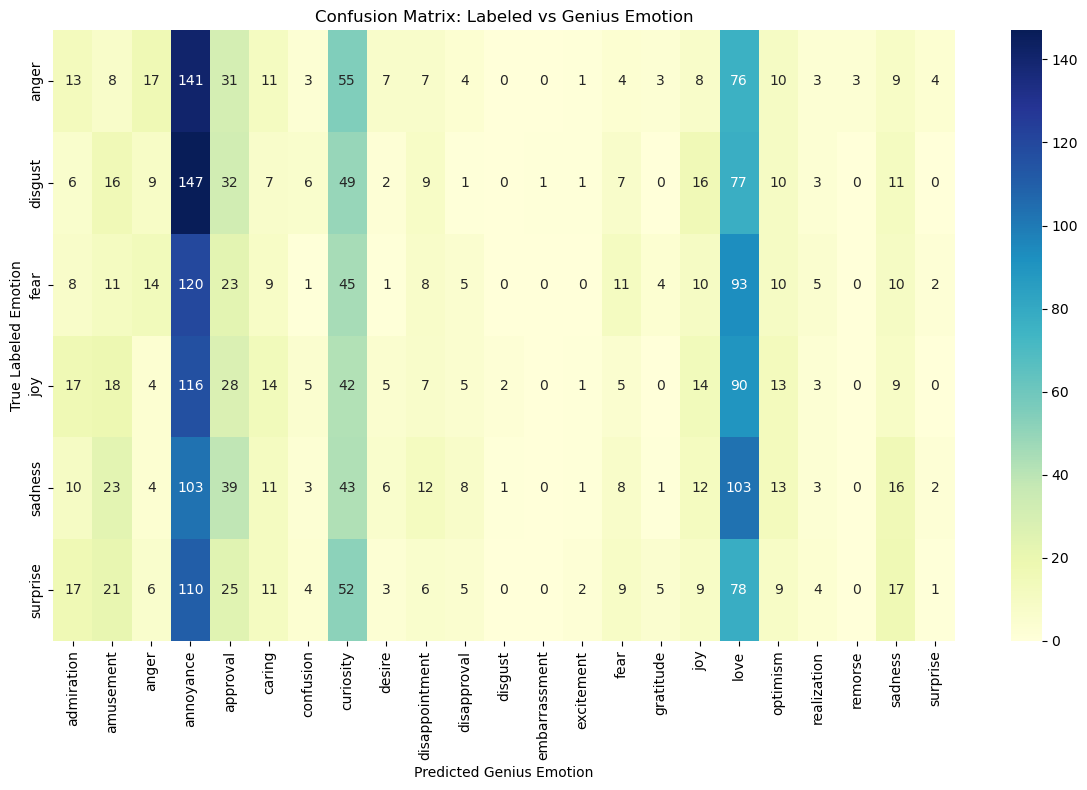

In [31]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Load data
df = pd.read_sql("SELECT labeled_emotion, genius_emotion FROM song_lyrics WHERE genius_emotion IS NOT NULL", sqlite3.connect("lyrics.db"))

# Filter out any rows where labeled_emotion is also missing
df = df.dropna(subset=["labeled_emotion", "genius_emotion"])

# Create confusion matrix
conf_matrix = pd.crosstab(df['labeled_emotion'], df['genius_emotion'])

# Plot heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='YlGnBu')
plt.title("Confusion Matrix: Labeled vs Genius Emotion")
plt.ylabel("True Labeled Emotion")
plt.xlabel("Predicted Genius Emotion")
plt.tight_layout()
plt.show()


In [35]:
# Re-initialize with truncation
emotion_classifier = pipeline(
    "text-classification",
    model="bhadresh-savani/bert-base-go-emotion",
    top_k=10,  # return top 10 to allow choosing one of the top 6
    framework="pt",
    device=-1,
    truncation=True  # <-- ensures text is truncated to max length
)

Device set to use cpu


In [38]:
# The six emotions from labeled_emotion 
six_emotions = {'surprise', 'sadness', 'joy', 'fear', 'disgust', 'anger'}

# Updated function: get top emotion in six_emotions
def classify_six_emotions_only(text):
    if not isinstance(text, str) or not text.strip():
        return None
    preds = emotion_classifier(text)
    for pred in preds[0]:  # Go through top 10 predictions
        label = pred['label'].lower()
        if label in six_emotions:
            return label
    return None  # No top predictions match the six emotions

# Apply function to DataFrame
df['six_genius_emotion'] = df['cleaned_lyrics'].apply(classify_six_emotions_only)


In [39]:
import sqlite3

# Connect to database
conn = sqlite3.connect("lyrics.db")
cursor = conn.cursor()

# Add column
try:
    cursor.execute("ALTER TABLE song_lyrics ADD COLUMN six_genius_emotion TEXT")
except sqlite3.OperationalError:
    print("Column already exists.")

# Update table with six genius emotions
for i, row in df[['track_id', 'six_genius_emotion']].dropna().iterrows():
    cursor.execute("""
        UPDATE song_lyrics
        SET six_genius_emotion = ?
        WHERE track_id = ?
    """, (row['six_genius_emotion'], row['track_id']))

conn.commit()
conn.close()
print("Updated six_genius_emotion in lyrics.db")


Updated six_genius_emotion in lyrics.db


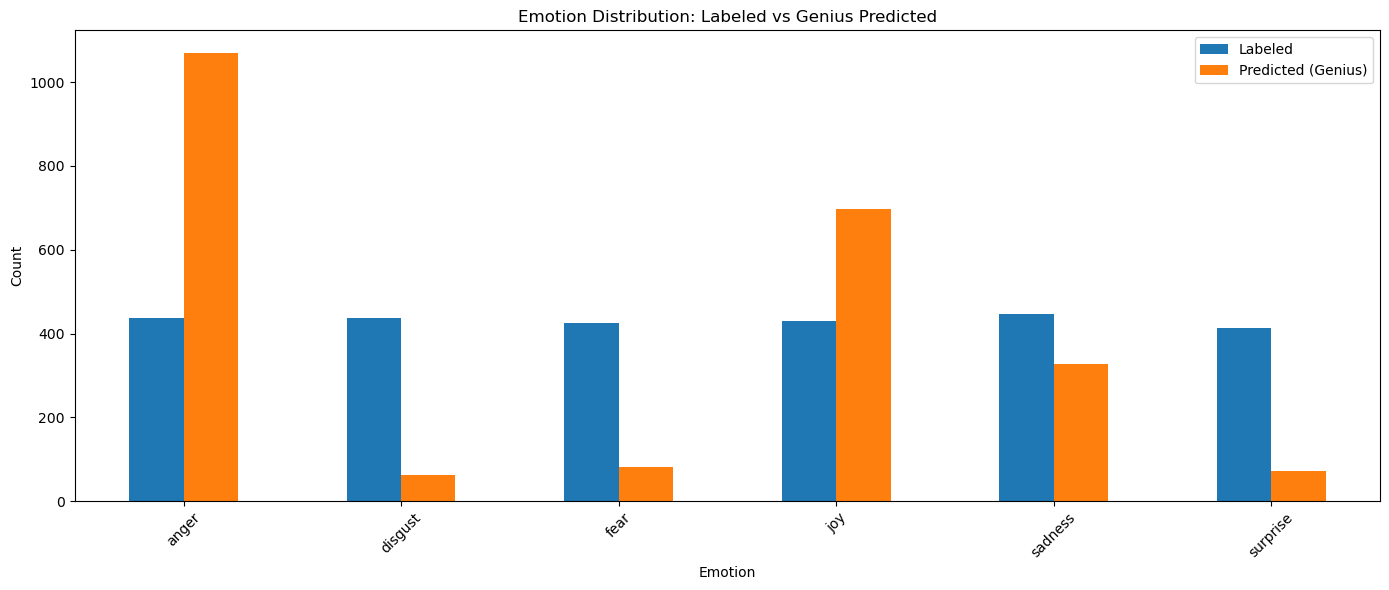

In [40]:
# Count frequencies
label_counts = df['labeled_emotion'].value_counts().sort_index()
genius_counts = df['six_genius_emotion'].value_counts().sort_index()

# Combine into single DataFrame
emotion_compare = pd.DataFrame({
    'Labeled': label_counts,
    'Predicted (Genius)': genius_counts
}).fillna(0)

# Plot
emotion_compare.plot(kind='bar', figsize=(14,6))
plt.title("Emotion Distribution: Labeled vs Genius Predicted")
plt.xlabel("Emotion")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

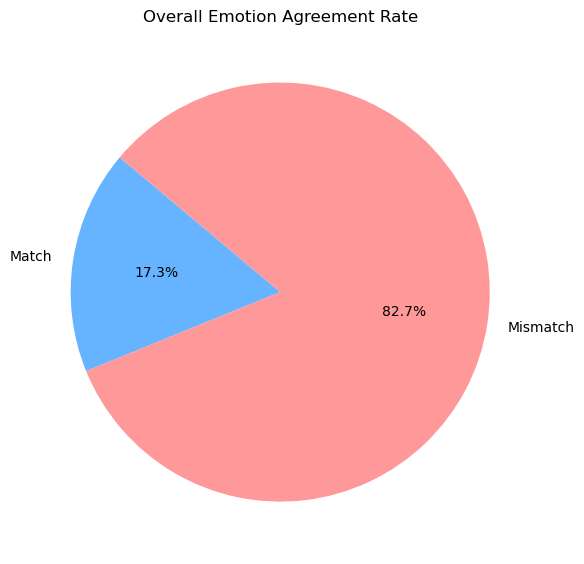

In [41]:
# Compute match rate
df['match'] = df['labeled_emotion'] == df['six_genius_emotion']
agreement_rate = df['match'].mean()

# Plot pie chart
plt.figure(figsize=(6, 6))
plt.pie([agreement_rate, 1 - agreement_rate],
        labels=['Match', 'Mismatch'],
        autopct='%1.1f%%',
        colors=['#66b3ff', '#ff9999'],
        startangle=140)
plt.title("Overall Emotion Agreement Rate")
plt.tight_layout()
plt.show()


In [44]:
# Connect to the database
conn = sqlite3.connect("lyrics.db")

# Load a sample of updated rows where genius_emotion is not NULL
sanity_df = pd.read_sql_query("""
    SELECT title, labeled_emotion, six_genius_emotion
    FROM song_lyrics
    WHERE genius_emotion IS NOT NULL
    LIMIT 100
""", conn)

conn.close()

# Display the results
print(sanity_df)

                                       title labeled_emotion  \
0                      Collapsing New People           anger   
1                   We Rule The Fucking Land           anger   
2                                      Blood           anger   
3                                    Deathly           anger   
4   My Definition Of A Boombastic Jazz Style         disgust   
..                                       ...             ...   
95                                      Sing           anger   
96                         Riders in the Sky             joy   
97                                 Let Me In             joy   
98                   Ticket Outta Loserville             joy   
99                 The Battle Of New Orleans             joy   

   six_genius_emotion  
0               anger  
1               anger  
2               anger  
3             sadness  
4               anger  
..                ...  
95           surprise  
96                joy  
97             